<a href="https://colab.research.google.com/github/sandratreneska/FLAME-fire-detection/blob/main/FLAMEmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os.path, random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Activation, BatchNormalization
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import sparse_categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib.pyplot as plt
import pickle

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check if GPU is connected
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [5]:
chosen_model_name = 'resnet50' # just change this for a different model

BASE_DIR = "/content/drive/My Drive/FLAME fire detection/" # change
IMG_PATH = BASE_DIR + "FLAME_dataset/Training"
IMG_HEIGHT = 254 
IMG_WIDTH = 254 
BATCH_SIZE = 64 # 32, 64, 128
LEARNING_RATE_1 = 3e-4 # 1e-3
LEARNING_RATE_2 = 5e-5
EPOCHS = 5

In [ ]:
# define a dictionary that maps model names to their classes inside Keras
MODELS = {
	"vgg16": tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
	"vgg19": tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
	"inception": tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
	"xception": tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)), 
	"resnet50": tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
}

# preprocessing function for each model
MODEL_PREPROCESS = {
  "vgg16": tf.keras.applications.vgg16.preprocess_input,
	"vgg19": tf.keras.applications.vgg19.preprocess_input,
	"inception": tf.keras.applications.inception_v3.preprocess_input,
	"xception": tf.keras.applications.xception.preprocess_input, 
	"resnet50": tf.keras.applications.resnet50.preprocess_input
}

chosen_model = MODELS[chosen_model_name]
chosen_preprocess = MODEL_PREPROCESS[chosen_model_name]

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# Image statistics

classes = []
for folder in os.listdir(IMG_PATH): 
      classes.append(folder)
      img_list = os.listdir(IMG_PATH + '/' + folder) 
      number_files = len(img_list)
      print("Number of images in directory", folder, "is:", number_files)
        
print("All classes: ", classes) 

Number of images in directory Fire is: 25018
Number of images in directory No_Fire is: 14368
All classes:  ['Fire', 'No_Fire']


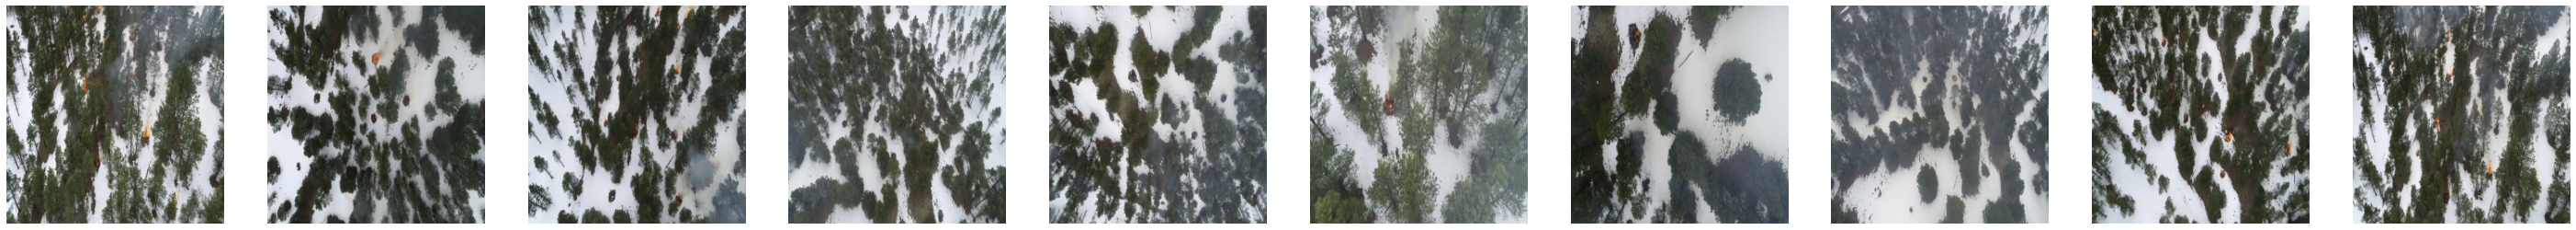

In [ ]:
# Plot random fire images
num_images = 10
fig = figure(figsize = (50,5)) 

for i in range(num_images):
  filename = random.choice(os.listdir(IMG_PATH + '/' + classes[0]))
  fig.add_subplot(1,num_images,i+1)
  image = imread(IMG_PATH + '/' + classes[0] + '/' + filename)
  imshow(image,cmap='Greys_r')
  axis('off')

In [ ]:
# Split data into train and validation datasets with real-time augmentation

# Training ImagaDataGenerator with Augmentation 
train_datagen = ImageDataGenerator(rotation_range=5, # 5 degrees
    horizontal_flip=True,
    data_format="channels_last",
    validation_split=0.2,
    dtype=tf.float32,
    preprocessing_function=chosen_preprocess)

# Validation ImageDataGenerator without Augmentation
valid_datagen = ImageDataGenerator(data_format="channels_last",
    validation_split=0.2,
    dtype=tf.float32,
    preprocessing_function=chosen_preprocess)


# Create a flow from the directory
train_data_gen = train_datagen.flow_from_directory(directory=IMG_PATH,
    subset='training',
    shuffle=True, 
    seed=123, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary")

# Create a flow from the directory for validation data, same seed 
val_data_gen = valid_datagen.flow_from_directory(directory=IMG_PATH, 
    subset='validation',
    shuffle=True, 
    seed=123, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary")

Found 31510 images belonging to 2 classes.
Found 7876 images belonging to 2 classes.


In [ ]:
# Define model with new dense layers
def create_model(chosen_model_name, chosen_model):

  loaded_model = chosen_model 
  loaded_model.trainable = False

  inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))  # x = loaded_model.output
  x = loaded_model(inputs, training=False) # training=False for batch norm
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)

  output = Dense(1, activation='sigmoid')(x) # binary
  model = keras.Model(inputs=inputs, outputs=output) # inputs=loaded_model.input

  return model

In [ ]:
# Create model
print("Creating " + chosen_model_name + " model with new fully connected layers")
model = create_model(chosen_model_name, chosen_model)
print(model.summary())

Creating resnet50 model with new fully connected layers
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 254, 254, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
# Save weights after each epoch
filepath = BASE_DIR + 'trainedEpochs/toptrained_'+chosen_model_name+'saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [ ]:
# Compile and train model 
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=LEARNING_RATE_1), metrics=["accuracy"])
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen, callbacks=[checkpoint])

Epoch 1/5
493/493 [==============================] - 10018s 20s/step - loss: 0.3334 - accuracy: 0.8583 - val_loss: 0.0681 - val_accuracy: 0.9590

Epoch 00001: saving model to /content/drive/My Drive/trainedEpochs/toptrained_resnet50saved-model-01-0.96.hdf5
Epoch 2/5
493/493 [==============================] - 499s 1s/step - loss: 0.0887 - accuracy: 0.9685 - val_loss: 0.0651 - val_accuracy: 0.9646

Epoch 00002: saving model to /content/drive/My Drive/trainedEpochs/toptrained_resnet50saved-model-02-0.96.hdf5
Epoch 3/5
493/493 [==============================] - 500s 1s/step - loss: 0.0587 - accuracy: 0.9805 - val_loss: 0.0675 - val_accuracy: 0.9655

Epoch 00003: saving model to /content/drive/My Drive/trainedEpochs/toptrained_resnet50saved-model-03-0.97.hdf5
Epoch 4/5
493/493 [==============================] - 500s 1s/step - loss: 0.0445 - accuracy: 0.9840 - val_loss: 0.0752 - val_accuracy: 0.9644

Epoch 00004: saving model to /content/drive/My Drive/trainedEpochs/toptrained_resnet50saved-

In [ ]:
# Save model
model.save(BASE_DIR + 'toptrained_'+chosen_model_name+'_model')

# Save history
with open(BASE_DIR + 'trainHistoryDict/toptrained_'+chosen_model_name+'_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/My Drive/toptrained_resnet50_model/assets


In [ ]:
#model = keras.models.load_model(BASE_DIR + 'toptrained_'+chosen_model_name+'_model')

In [ ]:
# Save weights after each epoch
filepath = BASE_DIR + 'trainedEpochs/finetuned_'+chosen_model_name+'saved-model-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [ ]:
# Fine-tune the whole model

for layer in model.layers: # Unfreeze all layers 
    layer.trainable = True

print(model.summary())
# Compile and train model 
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=LEARNING_RATE_2), metrics=["accuracy"])
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 254, 254, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
Epoch 1/5
493/493 [==============================] - 619s 1s/step - loss: 0.0473 - accuracy: 0.9860 - val

In [ ]:
# Save fine-tuned model
model.save(BASE_DIR + 'finetuned_'+chosen_model_name+'_model')

# Save history
with open(BASE_DIR + 'trainHistoryDict/finetuned_'+chosen_model_name+'_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)